In [7]:
import numpy as np
import pandas as pd
import fair
from matplotlib import pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize

# Get RCP modules
from fair.SSPs import ssp119, ssp126, ssp245, ssp370, ssp585

# Get RCP modules
from fair.RCPs import rcp26, rcp45, rcp60, rcp85

plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (16, 9)

In [11]:
def controllerPI(Temp_anomaly_array, time_step_position, control_temp, chunk_length, gain, G_i):
    geo = False
    for x in Temp_anomaly_array:
        if x > control_temp:
            geo = True
    if geo == False:
        rf = 0
    else: 
        first_year_of_geo = np.where(Temp_anomaly_array>control_temp)[0][0]
        Temp_anomaly_geo_period = Temp_anomaly_array[first_year_of_geo:]
        time_step_position_geo_period = time_step_position - first_year_of_geo
        P = Temp_anomaly_geo_period[time_step_position_geo_period-1] - control_temp  
        I = (Temp_anomaly_geo_period - control_temp)[0:time_step_position_geo_period-1].sum()
        rf = -np.clip(gain*(P + G_i*I),
                 a_min=0, a_max=10000)
    return np.repeat(rf,chunk_length)   
    
def trial_runPI(free_parameters, run_length, emissions, control_temp):
    #set up run
    run_length = run_length
    emissions_long = emissions
    chunk_length = 2
    control_temp = control_temp
    i = 0
    #controller free parameters
    free_parameters = free_parameters
    gain = free_parameters[0]
    G_i = free_parameters[1]
    #run 
    while i < emissions_long.size:
        if i == 0:
            C,F,T, restart = fair.forward.fair_scm(
            emissions=emissions_long[i:i+chunk_length],
            useMultigas= False,
            restart_out = True
            )
            Temperature_anomaly_C = T.copy()
        else:
            other_rf = controllerPI(Temperature_anomaly_C, i, control_temp, chunk_length, gain=gain, G_i=G_i)
            (C,F,T, restart) = fair.forward.fair_scm(
            emissions=emissions_long[i:i+chunk_length],
            other_rf=other_rf,
            useMultigas= False,
            restart_in = restart,
            restart_out = True
            )
            Temperature_anomaly_C = np.append(Temperature_anomaly_C, T, axis=0)
            #print(i, T, other_rf)
        i = i+chunk_length
    #create comparison with no geo 
    (C,F,T)= fair.forward.fair_scm(
        emissions=emissions_long,
        useMultigas= False)
    
    plt.plot(T, label='T without SAI')
    plt.plot(Temperature_anomaly_C, label='T with SAI')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('temperature above x, C')

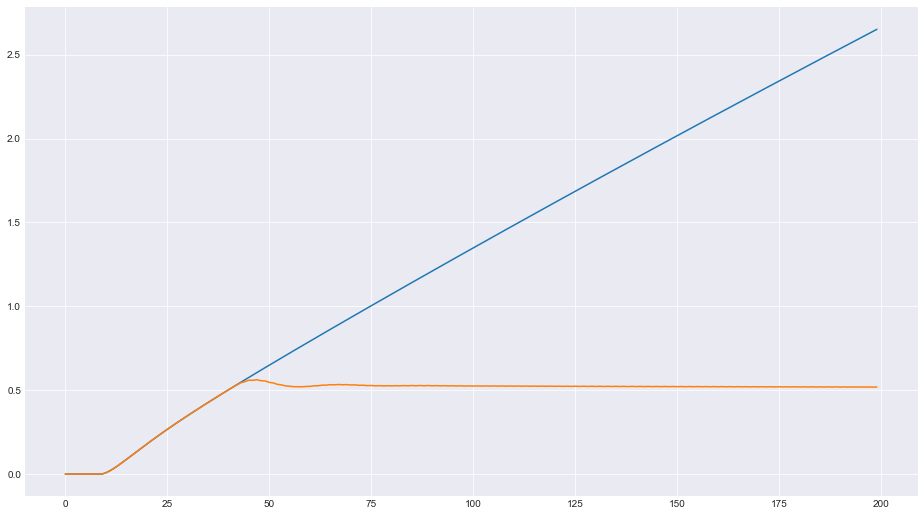

In [3]:
run_length = 200
emissions_long = np.zeros(run_length)
emissions_start = 10
emissions_long[emissions_start:] = 10.0 #GtC
trial_runPI([1,1], run_length=run_length, emissions=emissions_long, control_temp=0.5)

In [4]:
def error_score(free_parameters):
    gain = free_parameters[0]
    G_i = free_parameters[1]
    #set up training run
    run_length = 200
    emissions_long = np.zeros(run_length)
    emissions_start = 10
    emissions_long[emissions_start:] = 10.0 #GtC
    #emissions_long = rcp60.Emissions.co2_fossil 
    #run_length = len(emissions_long)
    chunk_length = 2
    control_temp = 0.5
    i = 0

    #run 
    while i < emissions_long.size:
        if i == 0:
            C,F,T, restart = fair.forward.fair_scm(
            emissions=emissions_long[i:i+chunk_length],
            useMultigas= False,
            restart_out = True
            )
            Temperature_anomaly_C = T.copy()
        else:
            other_rf = controllerPI(Temperature_anomaly_C, i, control_temp, chunk_length, gain=gain, G_i=G_i)
            (C,F,T, restart) = fair.forward.fair_scm(
            emissions=emissions_long[i:i+chunk_length],
            other_rf=other_rf,
            useMultigas= False,
            restart_in = restart,
            restart_out = True
            )
            Temperature_anomaly_C = np.append(Temperature_anomaly_C, T, axis=0)
            #print(i, T, other_rf)
        i = i+chunk_length

    #create comparison with no geo 
    (C,F,T)= fair.forward.fair_scm(
            emissions=emissions_long,
            useMultigas= False
            )
    #define success score as summed RMS difference with control temp, once geo begins  
    error = 0
    i=0
    for x in Temperature_anomaly_C:
        error = error + np.sqrt((Temperature_anomaly_C[i] - control_temp)**2)
        i=i+1    
    return error     

def optimize_free_parameters(initial_guess):
    initial_guess = initial_guess
    out = minimize(fun=error_score, x0=initial_guess)   
    return out.fun, out.x

(12.892775671813428, array([13.82054266,  0.72545775]))


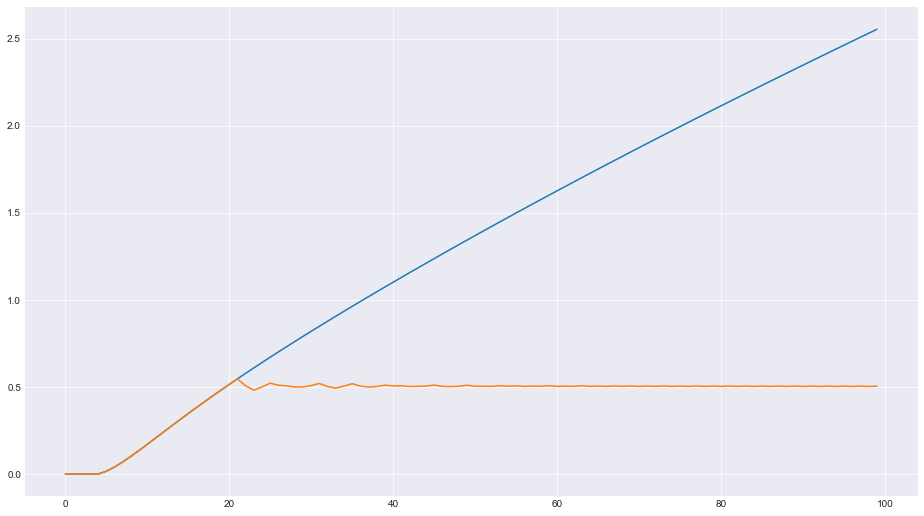

In [5]:
#test optimized version
outs = optimize_free_parameters([5,1])
print(outs)

run_length = 100
emissions_long = np.zeros(run_length)
emissions_start = 5
emissions_long[emissions_start:] = 20.0 #GtC

trial_runPI(free_parameters=outs[1], run_length = run_length, emissions = emissions_long, control_temp=0.5)

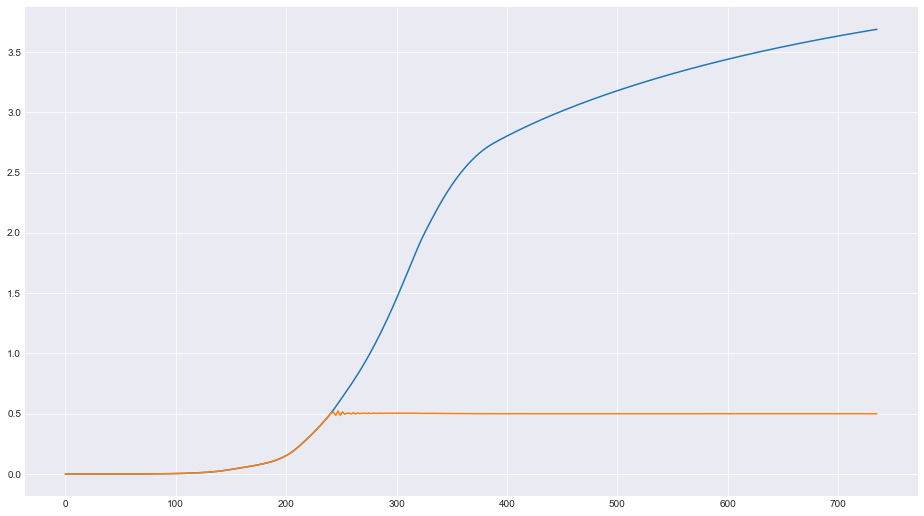

In [6]:
#try rcp60 as test
emissions_long = rcp60.Emissions.co2_fossil 
run_length = len(emissions_long)
trial_runPI(free_parameters=outs[1], run_length = run_length, emissions = emissions_long, control_temp=0.5)

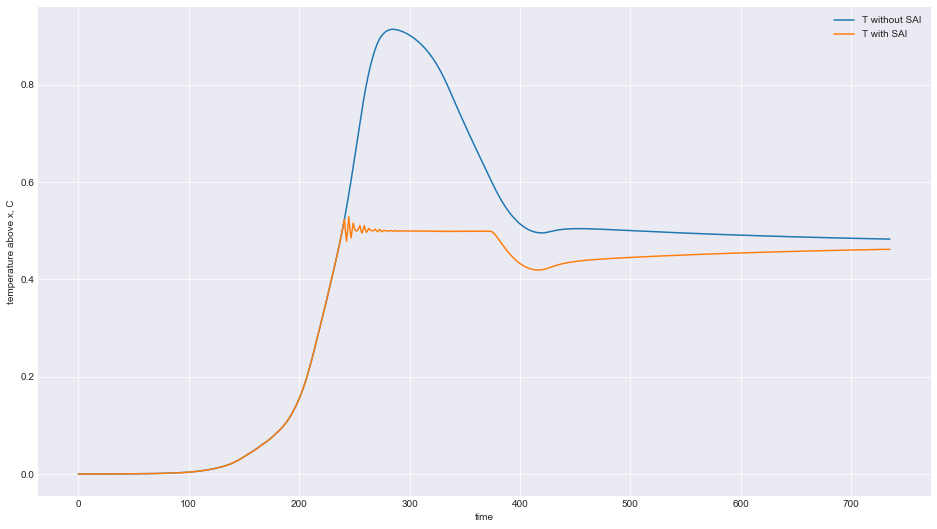

In [12]:
#try ssp1-1.9 as 2nd test
emissions_long = ssp119.Emissions.co2_fossil 
run_length = len(emissions_long)
trial_runPI(free_parameters=outs[1], run_length = run_length, emissions = emissions_long, control_temp=0.5)